# MountainCar-v0: Discretization

*Contact: Nagender Aneja, naneja@gmail.com, http://researchid.co/naneja

https://github.com/openai/gym/wiki/MountainCar-v0

<img src="https://miro.medium.com/proxy/1*nbCSvWmyS_BUDz_WAJyKUw.gif" width="300" height="300">

In [1]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=80)

In [2]:
env = gym.make('MountainCar-v0')
env.seed(505)

[505]

In [3]:
print('State Space ', env.observation_space) # Position and Velocity
print('Sample State Space ', env.observation_space.sample()) # Position and Velocity
print('Action Space ', env.action_space) # 0(push left), 1(no push), 2(push right)

# Reward -1 for each time step, until the goal position of 0.5 is reached. 
# As with MountainCarContinuous v0, there is no penalty for climbing the left hill, 
# which upon reached acts as a wall.

State Space  Box(2,)
Sample State Space  [-0.971 -0.004]
Action Space  Discrete(3)


In [4]:
# Random Agent
state = env.reset()
score = 0

for t in range(200):
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        print('Won!')
        break
print('Final Score {}'.format(score))
env.close()

Won!
Final Score -200.0


In [5]:
print('State Space ', env.observation_space)

print(' * Low ', env.observation_space.low)
print(' * High ', env.observation_space.high)

State Space  Box(2,)
 * Low  [-1.2  -0.07]
 * High  [0.6  0.07]


In [6]:
samples = np.array([env.observation_space.sample() for i in range(10)])
print(samples)

[[-0.452 -0.023]
 [-0.579 -0.056]
 [-0.382  0.03 ]
 [ 0.588  0.052]
 [-0.954  0.03 ]
 [-0.159  0.026]
 [ 0.379 -0.01 ]
 [-0.335  0.013]
 [-0.788 -0.028]
 [ 0.563 -0.064]]


In [7]:
print('Action Space ', env.action_space)
samples = np.array([env.action_space.sample() for i in range(10)])
print(samples)

Action Space  Discrete(3)
[2 1 0 2 0 1 2 2 2 0]


## Discretize the State Space with a Uniform Grid

In [8]:
def create_uniform_grid(low, high, bins=(10,10)):
    x = np.linspace(low[0], high[0], bins[0], endpoint=False)[1:]
    y = np.linspace(low[1], high[1], bins[1], endpoint=False)[1:]
    grid = [x, y]
    return grid
low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

In [9]:
def discretize(sample, grid):
    gx = int(np.digitize(sample[0], grid[0]))
    gy = int(np.digitize(sample[1], grid[1]))
    g = [gx, gy]
    return g

In [10]:
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])

In [11]:
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])

# There may be one-off differences in binning due to floating-point inaccuracies 
# when samples are close to grid boundaries
print(grid)
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]), array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


## Visualization for introduced error due to discretization

In [12]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    fig, ax = plt.subplots(figsize=(10,10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)

    if low is None or high is None:
        x, y = grid[0], grid[1]
        low = [x[0], y[0]]
        high = [x[-1], y[-1]]
    else:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])

    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T)) # add low, high
    grid_extended_LB = grid_extended[:, :-1]
    grid_extended_TU = grid_extended[:, 1:]
    grid_centers = (grid_extended_LB + grid_extended_TU) / 2 

    x = discretized_samples[:, 0]
    y = discretized_samples[:, 1]

    gx = grid_centers[0, x] # pick grid centre for each x
    gy = grid_centers[1, y] # pick grid centre for each x
    locs = np.stack([gx, gy], axis=1)

    print(samples.shape, locs.shape)
    ax.plot(samples[:, 0], samples[:, 1], 'o', label='original')
    ax.plot(locs[:, 0], locs[:, 1], 's', label='discretized')
    ax.legend()
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))

(8, 2) (8, 2)


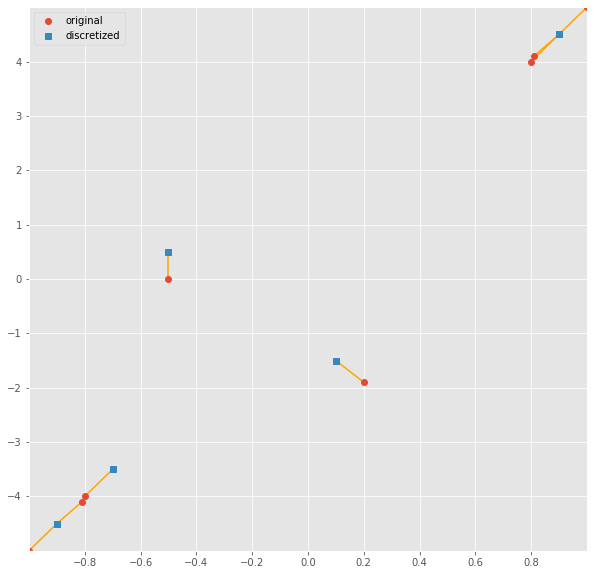

In [13]:
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])

state_grid = create_uniform_grid(low=[-1.0, -5.0], high=[1.0, 5.0], bins=(10,10))

discretized_samples = np.array([discretize(sample, grid) for sample in samples])

visualize_samples(samples, discretized_samples, grid, low, high)

## Apply to MountainCar-v0

In [14]:
state_low, state_high = env.observation_space.low, env.observation_space.high

state_grid = create_uniform_grid(low=state_low, high=state_high, bins=(10,10))

state_grid

[array([-1.02, -0.84, -0.66, -0.48, -0.3 , -0.12,  0.06,  0.24,  0.42]),
 array([-0.056, -0.042, -0.028, -0.014,  0.   ,  0.014,  0.028,  0.042,  0.056])]

(10, 2) (10, 2)


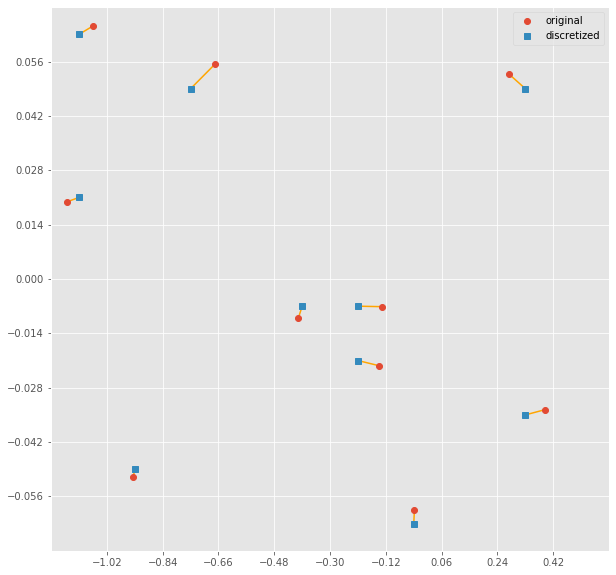

In [15]:
state_samples = [env.observation_space.sample() for i in range(10)]
state_samples = np.array(state_samples)

discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])

visualize_samples(state_samples, discretized_state_samples, state_grid, state_low, state_high)

## Q-Learning

In [16]:
class QLearningAgent:
    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99, epsilon=1.0, \
                 epsilon_decay_rate=0.9995, min_epsilon=0.01, seed=505):
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(dim) + 1 for dim in self.state_grid)
        self.action_size = self.env.action_space.n 
        self.seed = np.random.seed(seed)
        print('Environment: ', self.env)
        print('State Space Size: ', self.state_size)
        print('Action Space Size: ', self.action_size)
        
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = self.initial_epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon
        
        shape = self.state_size + (self.action_size, ) # tuple concatenation
        self.q_table = np.zeros(shape=shape)
        print("Q table size:", self.q_table.shape) # loc(10), vel(10), act(3)
        
    def preprocess_state(self, state):
        g = discretize(state, self.state_grid)
        return tuple(g)
    
    def reset_episode(self, state):
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state]) # initial action
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
    
    def act(self, state, reward=None, done=None, mode='train'):
        state = self.preprocess_state(state)
        if mode == 'test':
            action = np.argmax(self.q_table[state])
        else:
            t = self.last_state + (self.last_action, )
            qs = self.q_table[state]
            self.q_table[t] += self.alpha * (reward + self.gamma * max(qs) - self.q_table[t])
            
            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                action = np.random.randint(0, self.action_size)
            else:
                action = np.argmax(self.q_table[state])

        self.last_state = state
        self.last_action = action
        return action

In [17]:
q_agent = QLearningAgent(env, state_grid)

Environment:  <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State Space Size:  (10, 10)
Action Space Size:  3
Q table size: (10, 10, 3)


In [18]:
# Run agent in given reinforcement learning environment and return scores
def run(agent, env, num_episodes=20000, mode='train'):
    scores = []
    max_avg_score = -np.Inf
    for i in range(1, num_episodes+1):
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False
        
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            
            action = agent.act(state, reward, done, mode)
        scores.append(total_reward)
        
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:]) # Last 100
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i % 100 == 0:
                print('\rEpisode {}/{} Max Avg Score: {}'.format(i, num_episodes, max_avg_score),
                      end='')
                sys.stdout.flush()
    return scores

In [19]:
env = gym.make('MountainCar-v0')
env.seed(505)

state_low, state_high = env.observation_space.low, env.observation_space.high

state_grid = create_uniform_grid(low=state_low, high=state_high, bins=(10,10))

state_grid

[array([-1.02, -0.84, -0.66, -0.48, -0.3 , -0.12,  0.06,  0.24,  0.42]),
 array([-0.056, -0.042, -0.028, -0.014,  0.   ,  0.014,  0.028,  0.042,  0.056])]

In [20]:
q_agent = QLearningAgent(env, state_grid)
scores = run(q_agent, env)

Environment:  <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State Space Size:  (10, 10)
Action Space Size:  3
Q table size: (10, 10, 3)
Episode 20000/20000 Max Avg Score: -130.49

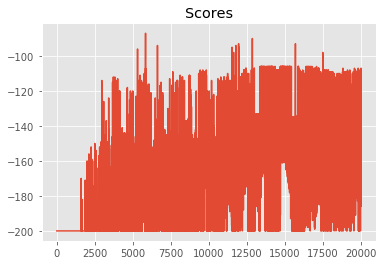

In [21]:
plt.plot(scores)
plt.title('Scores');

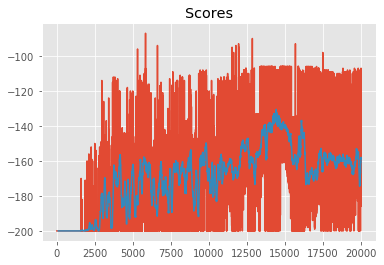

In [22]:
# Plot scores and optional rolling mean using specified window
def plot_scores(scores, rw=100):
    plt.plot(scores)
    plt.title('Scores')
    
    rm = pd.Series(scores).rolling(rw).mean()
    plt.plot(rm)
    
    return rm

rolling_mean = plot_scores(scores)

## Test Mode

[TEST] 100 episodes with -146.91 avg score


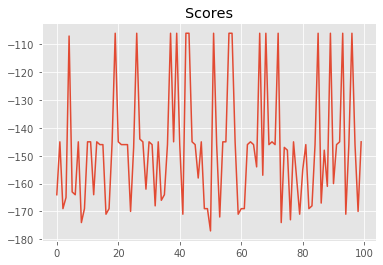

In [23]:
test_scores = run(q_agent, env, num_episodes=100, mode='test')

print('[TEST] {} episodes with {} avg score'.format(len(test_scores), np.mean(test_scores)))

_ = plot_scores(test_scores)

## Q-Table

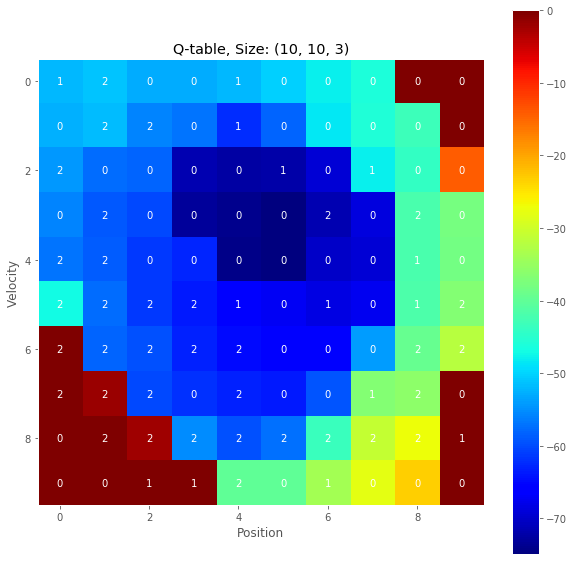

In [24]:
# Visualize max Q-value for each state and corresponding action.
def plot_q_table(q_table):
    q_image = np.max(q_table, axis=2)
    q_actions = np.argmax(q_table, axis=2)
    
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.imshow(q_image, cmap='jet')
    cbar = fig.colorbar(cax)
    
    xs, ys = q_image.shape[0], q_image.shape[1]
    for x in range(xs):
        for y in range(ys):
            a = q_actions[x, y]
            ax.text(x, y, a, color='w', horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    
    ax.set_title('Q-table, Size: {}'.format(q_table.shape))
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    
    
plot_q_table(q_agent.q_table)

# Modify the Grid

In [25]:
state_grid_new = create_uniform_grid(env.observation_space.low, env.observation_space.high, 
                                     bins=(20,20))
q_agent_new = QLearningAgent(env, state_grid_new)

q_agent_new.scores = []

Environment:  <TimeLimit<MountainCarEnv<MountainCar-v0>>>
State Space Size:  (20, 20)
Action Space Size:  3
Q table size: (20, 20, 3)


In [ ]:
q_agent_new.scores += run(q_agent_new, env, num_episodes=50000, mode='train')

rolling_mean_new = plot_scores(q_agent_new.scores)

Episode 39600/50000 Max Avg Score: -121.99

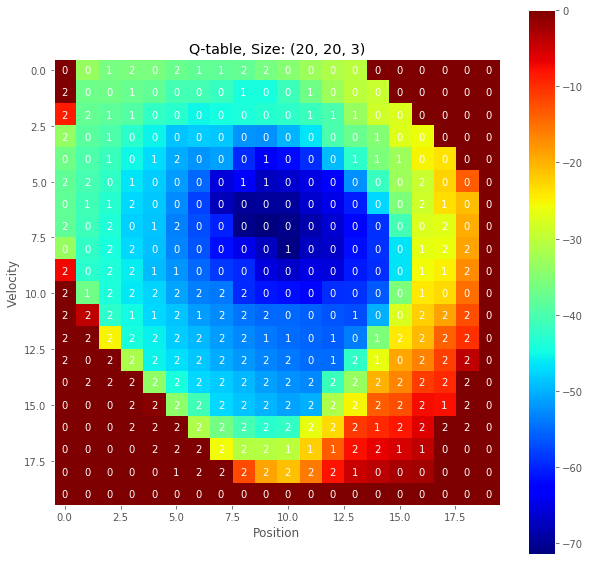

In [30]:
plot_q_table(q_agent_new.q_table)

# Watch

In [34]:
state = env.reset()
score = 0

for t in range(200):
    action = q_agent_new.act(state, mode='test')
    env.render()
    state, reward, done, info = env.step(action)
    score += reward
    if done:
        break
print('Final Score: {}'.format(score))
env.close()

Final Score: -107.0
